In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import matplotlib.pyplot as plt
import dask

In [24]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 15  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [25]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.4235abae7e32430faf050c6045460a4e/status,


In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds.zarr'))

In [3]:
ds = ds.sortby(ds.latitude)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (time: 6485, expver: 2, latitude: 721, longitude: 1440)
Coordinates:
  * expver     (expver) int32 1 5
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-09-28T04:00:00
Data variables:
    e          (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    ro         (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    slhf       (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    sro        (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    sshf       (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    ssr        (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    ssrd       (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    ssro       (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    sst        (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    str        (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
    strd       (time, expver, latitude, longitude) float32 dask.array<chunksize=(15, 2, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-03 04:19:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Create mask object

In [18]:
hfacc = ds.sst.where(ds.sst == ds.sst.notnull(), 999).where(ds.sst < 999, np.nan)

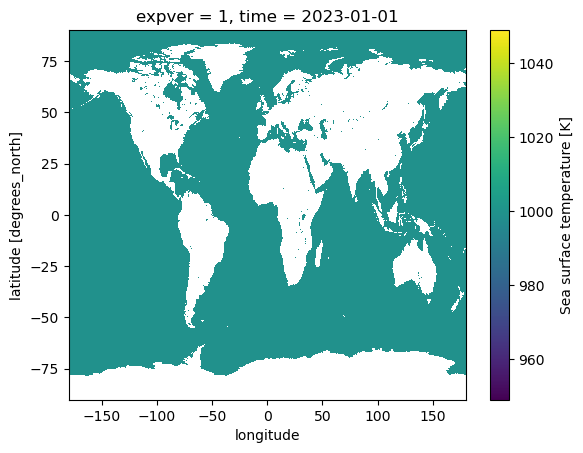

In [38]:
hfacc[0,0].plot()

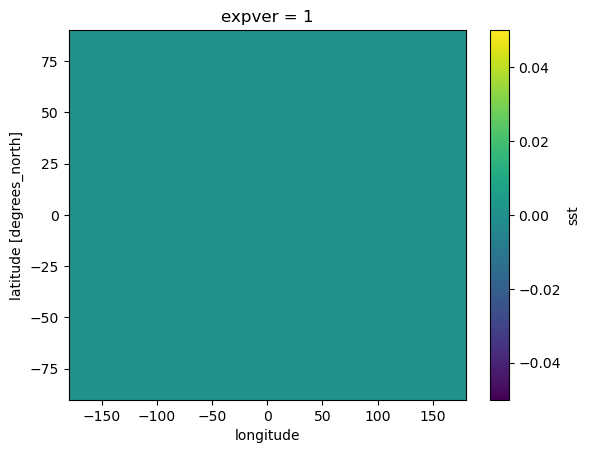

In [39]:
hfacc.isel(expver=0).std(dim='time').plot()

In [19]:
mask = hfacc[0,0]

## Focus in on Gulf region

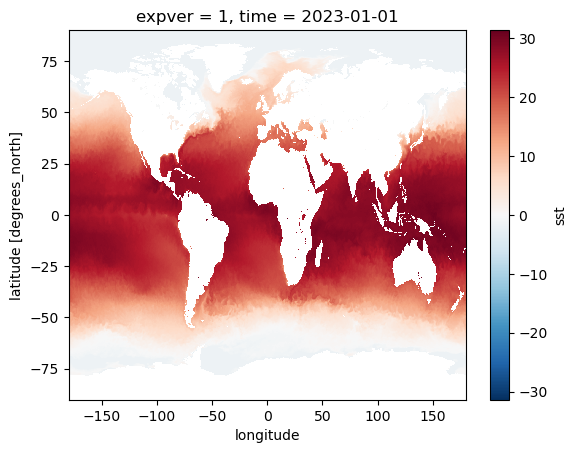

In [11]:
(ds.sst.isel(expver=0, time=0)-273.15).plot()

In [5]:
gulf = dict(longitude=slice(-100, 0), latitude=slice(8, 35))

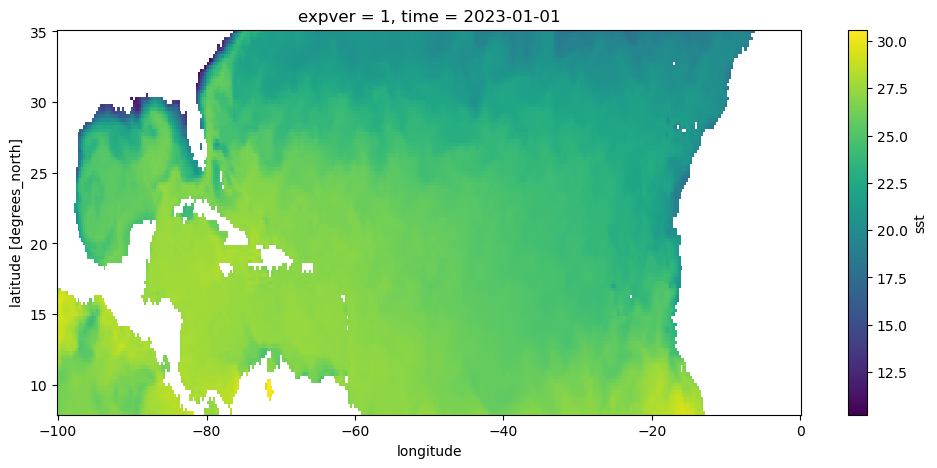

In [6]:
(ds.sst.isel(expver=0, time=0).sel(**gulf) - 273.15).plot(figsize=(12,5))

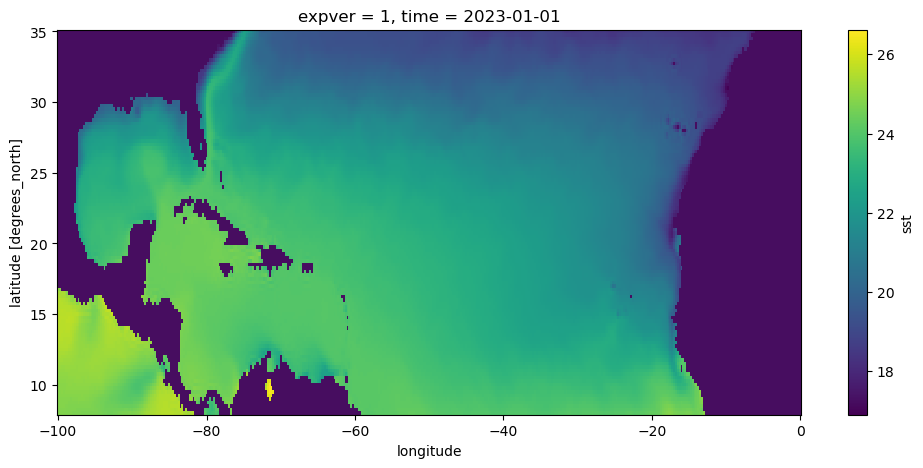

In [45]:
(ds.sst.isel(expver=0).sel(**gulf) - 273.15).mean('time').where(mask).plot(figsize=(12,5))

In [9]:
sst_trop = ds.sst.isel(expver=0).sel(**gulf) - 273.15

In [15]:
sst_trop

<xarray.DataArray 'sst' (time: 6485, latitude: 109, longitude: 401)>
dask.array<sub, shape=(6485, 109, 401), dtype=float32, chunksize=(15, 109, 401), chunktype=numpy.ndarray>
Coordinates:
    expver     int32 1
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-09-28T04:00:00

In [7]:
import cmocean

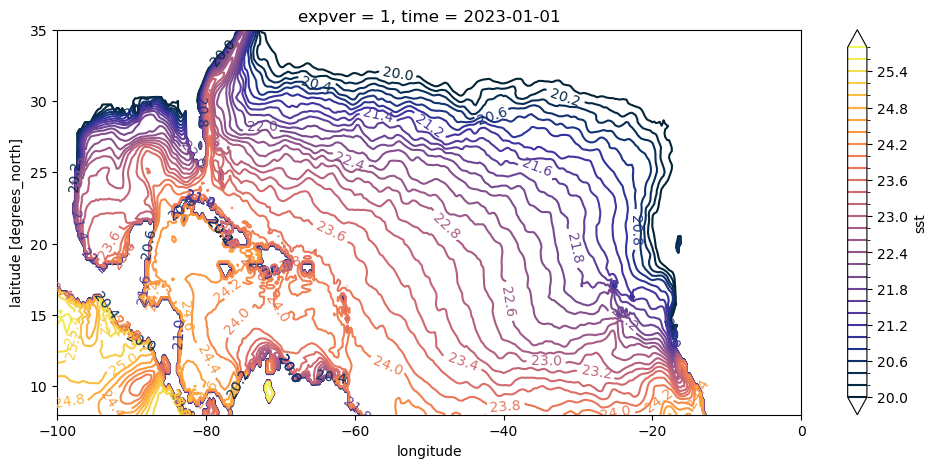

In [22]:
theta_levs = np.arange(20,26,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).mean('time').where(mask).plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

Text(0.5, 1.0, 'Averaged 2023 SST')

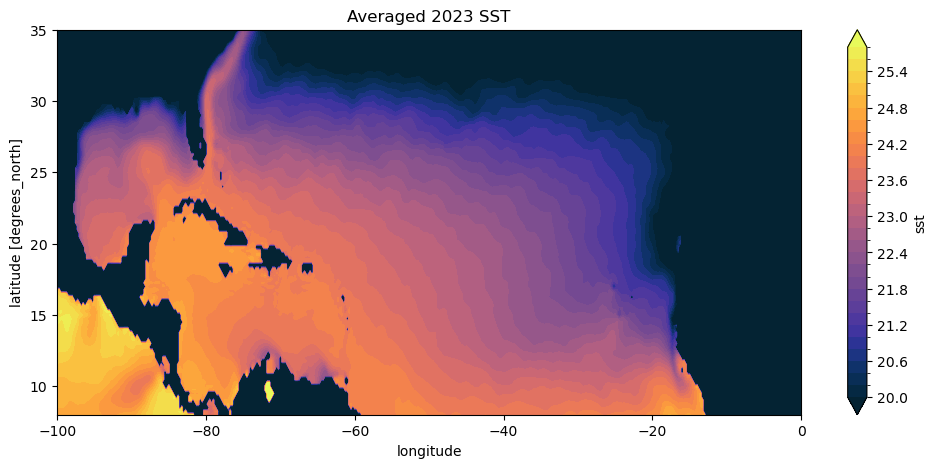

In [21]:
theta_levs = np.arange(20,26,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2023 SST')

## Fixed threshold

In [10]:
clim = sst_trop.groupby('time.month').mean()
anom = sst_trop.groupby('time.month') - clim

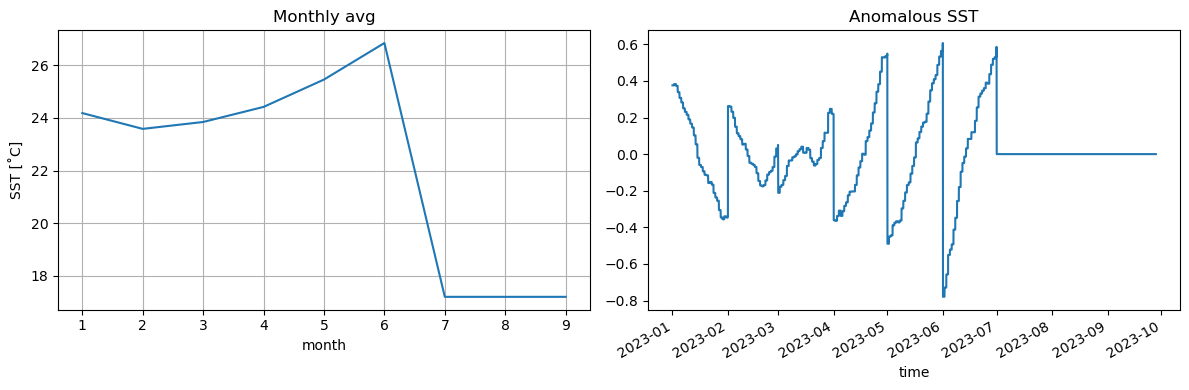

In [16]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

clim.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('Monthly avg')
anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
plt.tight_layout();

In [13]:
anom

<xarray.DataArray 'sst' (time: 6485, latitude: 109, longitude: 401)>
dask.array<sub, shape=(6485, 109, 401), dtype=float32, chunksize=(15, 109, 401), chunktype=numpy.ndarray>
Coordinates:
    expver     (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-09-28T04:00:00
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 9 9 9 9 9 9 9 9 9 9 9 9

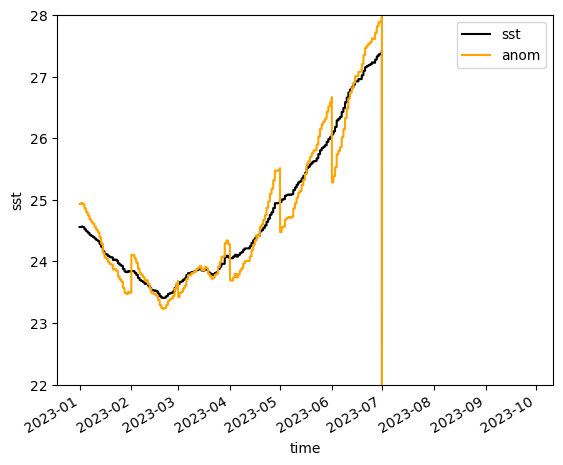

In [55]:
sst_trop.mean(['latitude', 'longitude']).plot(label='sst', color='k')
(sst_trop+anom).mean(['latitude', 'longitude']).plot(label='anom', color='orange')
plt.ylim(22,28)
plt.legend();

In [31]:
avg_sst_trop = sst_trop.mean(['latitude', 'longitude'])
avg_anom = (sst_trop+anom).mean(['latitude', 'longitude'])
hot = avg_anom.where(avg_anom > avg_sst_trop)
cold = avg_anom.where(avg_anom < avg_sst_trop)
hw = avg_anom.where(avg_anom > 27)
cs = avg_anom.where(avg_anom < 21)

In [26]:
hot

<xarray.DataArray 'sst' (time: 6485)>
dask.array<where, shape=(6485,), dtype=float32, chunksize=(15,), chunktype=numpy.ndarray>
Coordinates:
    expver   (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-09-28T04:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 9 9 9 9 9 9 9 9 9 9 9 9

(22.0, 28.0)

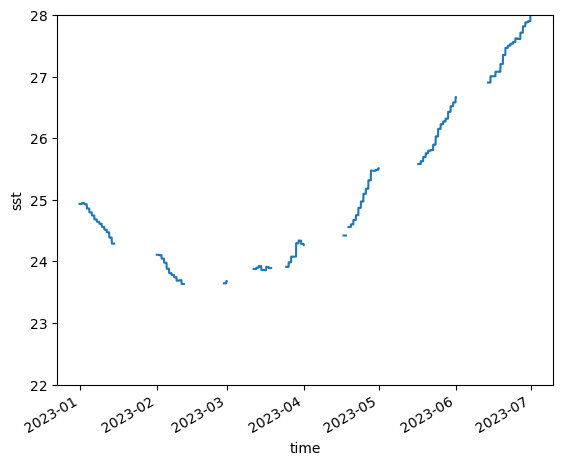

In [28]:
hot.plot()
plt.ylim(22,28)

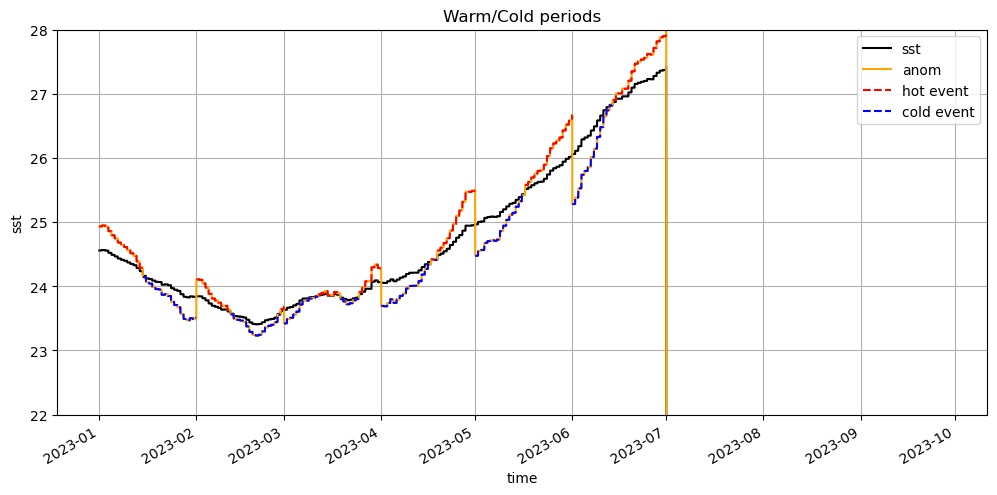

In [32]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hot.plot(label='hot event', color='red', linestyle='dashed')
cold.plot(label='cold event', color='blue', linestyle='dashed')

plt.ylim(22,28)
plt.grid()
plt.legend()
plt.title('Warm/Cold periods');

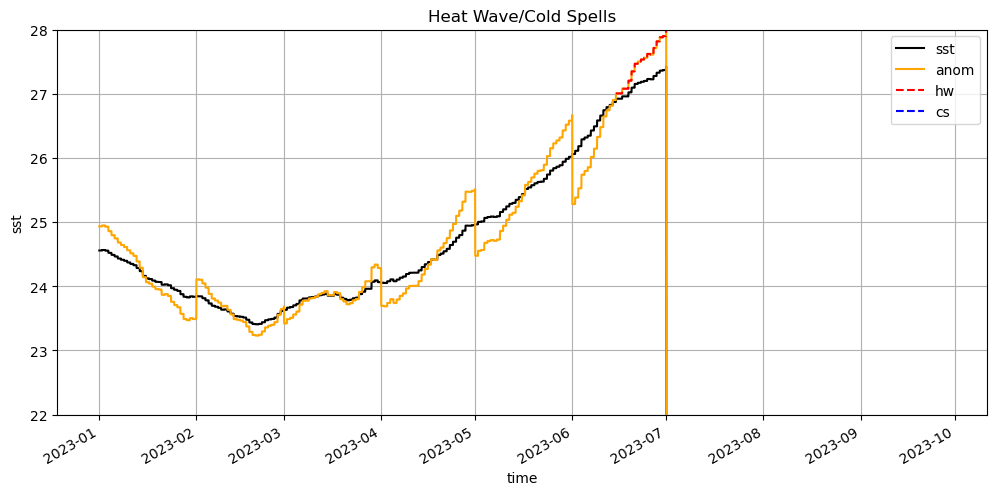

2023-10-05 20:44:26,196 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [33]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hw.plot(label='hw', color='red', linestyle='dashed')
cs.plot(label='cs', color='blue', linestyle='dashed')

plt.ylim(22,28)
plt.grid()
plt.legend()
plt.title('Heat Wave/Cold Spells');

In [22]:
client.close()
cluster.close()